# Import libraries and set random seed

In [1]:
import sys
import copy
import time

import numpy as np
import torch
import matplotlib.pyplot as plt

from graph_deep_decoder import datasets as ds
from graph_deep_decoder.architecture import GraphDecoder
from graph_deep_decoder.model import Model

SEED = 9  # 9  # 15
torch.manual_seed(SEED)
np.random.seed(SEED)

# Creating random SBM graph

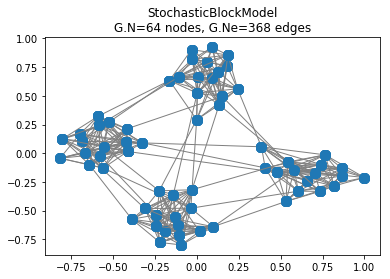

In [2]:
Gs = {}
Gs['type'] = ds.SBM
Gs['N'] = 64  # 256  # 64
Gs['k'] = 4
Gs['p'] = 0.7  # 0.25  # 0.6
Gs['type_z'] = ds.CONT
Gs['q'] = 0.015  # 0.004  # 0.015
#Gs['q'] = [[0, 0.0075, 0, 0.0],
#           [0.0075, 0, 0.004, 0.0025],
#           [0, 0.004, 0, 0.005],
#           [0, 0.0025, 0.005, 0]]

G = ds.create_graph(Gs, SEED)

A = G.W.todense()
L = G.L.todense()
G.plot()

# Create graph filters 

In [3]:
K = 3
#hs = [0.4, 0.4, 0.1, 0.05, 0.05]
hs = np.random.rand(K)
hs /= np.sum(hs)
print('Filter coeefs:', hs)
x_dw = ds.DiffusedWhiteGS(G, ds.NonLin.NONE, K, coefs=hs)
x_dw.to_unit_norm()
H = x_dw.H


Filter coeefs: [0.01029159 0.49788057 0.49182783]


# Analyze Jacobian

In [4]:
fts = 100  # 300  # 600
dec = GraphDecoder(fts, H)
dec_copy = copy.deepcopy(dec)

# Get JJ^T by applaying the formula
def get_jacobian_squared_analytic(net):
    U = net.input.numpy().squeeze()
    C = net.conv.weight.data.numpy().squeeze().T
    diag_v = np.diag(net.v.numpy().squeeze())
    return (U.dot(C)>0).dot(diag_v**2).dot((U.dot(C)>0).T)*(U.dot(U.T))

# Get the Jacobian by using autograd 
def get_jacobian_autograd(net):
    y = net(net.input)
    outs = torch.eye(y.shape[0])
        
    jac = []
    for out in outs:
        y = net(net.input)
        y.backward(out[:])
        allgrads = []
        for p in net.parameters():
            gra = p.grad.data.numpy().flatten()
            allgrads += [gra] 
        jac += [allgrads]
    return np.array(jac).squeeze()


JJ_an = get_jacobian_squared_analytic(dec)

model = Model(dec_copy, epochs=1)
model.fit(x_dw.x)
Jac = get_jacobian_autograd(model.arch)
JJ_aut = Jac.dot(Jac.T)

t1 = time.time()
Sigmas_an, U_an = np.linalg.eig(JJ_an)
Sigmas_aut, U_aut = np.linalg.eig(JJ_aut)
print('Time for computing eig:', time.time()-t1)

Time for computing eig: 0.0029916763305664062


## Autograd Jacobian eigenvectors/eigenvalues

Text(0.5,1,'Eigvalues JJ^T')

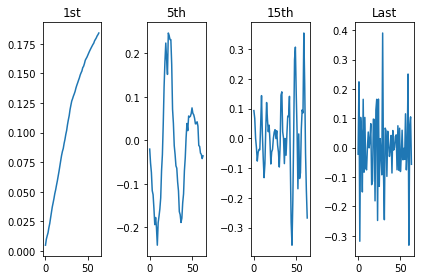

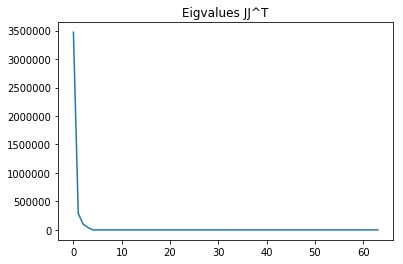

In [5]:
# Autogradient Jacobians eigendecomposition
plt.figure()
plt.subplot(141)
plt.plot(U_aut[:,0])
plt.title('1st')
plt.subplot(142)
plt.plot(U_aut[:,4])
plt.title('5th')
plt.subplot(143)
plt.plot(U_aut[:,14])
plt.title('15th')
plt.subplot(144)
plt.plot(U_aut[:,-1])
plt.title('Last')
plt.tight_layout()

plt.figure()
plt.plot(Sigmas_aut)
plt.title('Eigvalues JJ^T')

## Analytical Jacobian eigenvectors/eigenvalues

Text(0.5,1,'Eigvalues JJ^T')

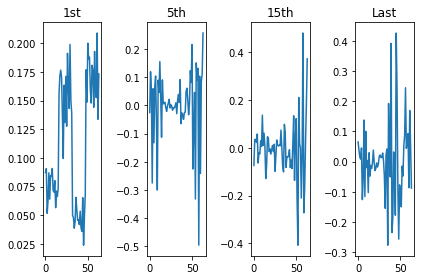

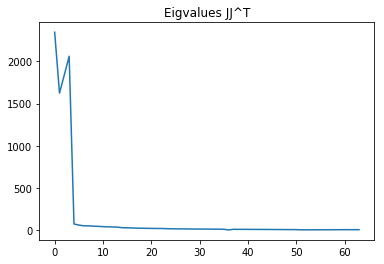

In [6]:
# Analytical Jacobians eigendecomposition
plt.figure()
plt.subplot(141)
plt.plot(U_an[:,0])
plt.title('1st')
plt.subplot(142)
plt.plot(U_an[:,4])
plt.title('5th')
plt.subplot(143)
plt.plot(U_an[:,14])
plt.title('15th')
plt.subplot(144)
plt.plot(U_an[:,-1])
plt.title('Last')
plt.tight_layout()

plt.figure()
plt.plot(Sigmas_an)
plt.title('Eigvalues JJ^T')


## Smoothness on L

Eigv 1: Smoothness over L: 0.41983736691138435
Eigv 2: Smoothness over L: 1.1690266942529584
Eigv 5: Smoothness over L: 10.229221891396062
Eigv 15: Smoothness over L: 13.79928355777285
Eigv last: Smoothness over L: 10.97876018825046


Text(0.5,0,'Eigenvectors')

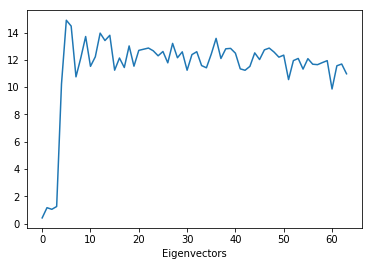

In [7]:
smoothness = np.diag(U_an.T.dot(L).dot(U_an))
print('Eigv 1: Smoothness over L:', smoothness[0])
print('Eigv 2: Smoothness over L:', smoothness[1])
print('Eigv 5: Smoothness over L:', smoothness[4])
print('Eigv 15: Smoothness over L:', smoothness[14])
print('Eigv last: Smoothness over L:', smoothness[-1])

plt.figure()
plt.plot(smoothness)
plt.xlabel('Eigenvectors')

## Compare with eigendecomposition of A

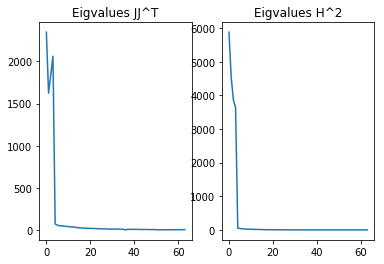

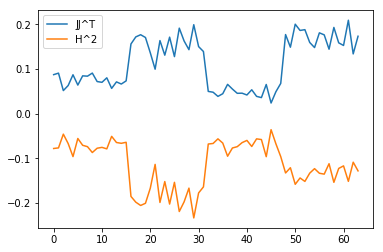

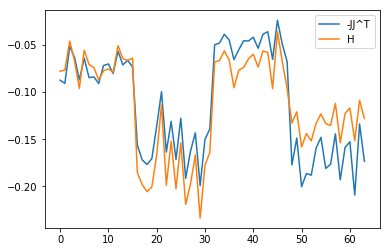

In [8]:
eigval_H, V_H = np.linalg.eig(H)
# make sure eigenvalues are sorted
idx = np.flip(np.argsort(eigval_H), axis=0)
eigval_H = eigval_H[idx]
V_H = V_H[:, idx]

plt.subplot(121)
plt.plot(Sigmas_an)
plt.title('Eigvalues JJ^T')
plt.subplot(122)
plt.plot(eigval_H**2)
plt.title('Eigvalues H^2')

plt.figure()
plt.plot(U_an[:,0])
plt.plot(V_H[:,0])
plt.legend(['JJ^T','H^2'])

plt.figure()
plt.plot(-U_an[:,0])
plt.plot(V_H[:,0])
plt.legend(['-JJ^T','H'])

## Expected Squared Jacobian

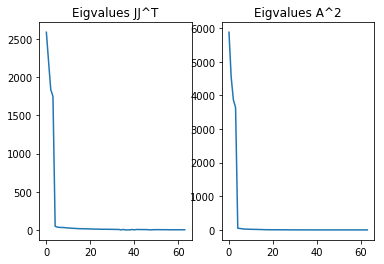

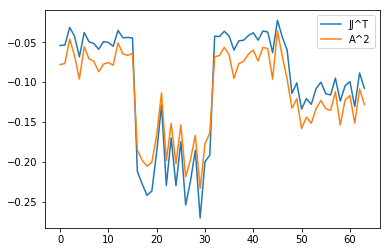

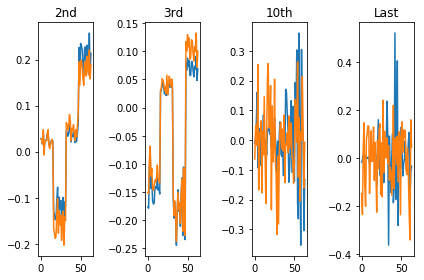

In [9]:
samples = 10000
Exp_JJ = np.zeros((G.N, G.N))
for i in range(samples):
    Exp_JJ += get_jacobian_squared_analytic(GraphDecoder(K, H))/samples

Exp_S, Exp_U = np.linalg.eig(Exp_JJ)

plt.subplot(121)
plt.plot(Exp_S)
plt.title('Eigvalues JJ^T')
plt.subplot(122)
plt.plot(eigval_H**2)
plt.title('Eigvalues A^2')

plt.figure()
plt.plot(-Exp_U[:, 0])
plt.plot(V_H[:, 0])
plt.legend(['JJ^T','A^2'])

plt.figure()
plt.subplot(141)
plt.plot(-Exp_U[:, 1])
plt.plot(V_H[:,1])
plt.title('2nd')
plt.subplot(142)
plt.plot(-Exp_U[:, 2])
plt.plot(V_H[:,2])
plt.title('3rd')
plt.subplot(143)
plt.plot(Exp_U[:, 9])
plt.plot(V_H[:,9])
plt.title('10th')
plt.subplot(144)
plt.plot(Exp_U[:, -1])
plt.plot(V_H[:,-1])
plt.title('Last')
plt.tight_layout()

Eig 0 rotated
Eig 2 rotated


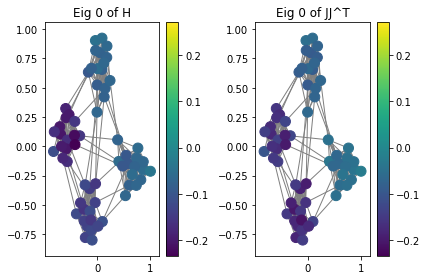

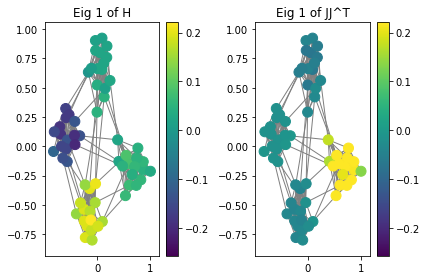

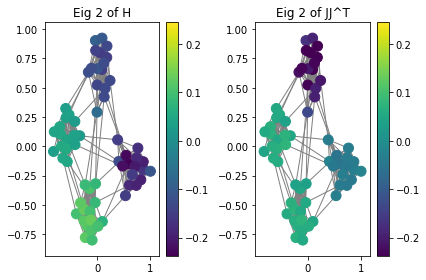

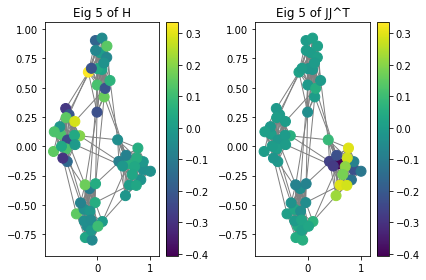

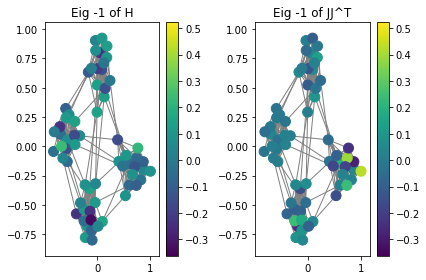

In [10]:
eig_inds = [0, 1, 2, 5, -1]
for eig_ind in eig_inds:
    bot_lim = np.min([V_H[:, eig_ind], Exp_U[:, eig_ind]])
    up_lim = np.max([V_H[:, eig_ind], Exp_U[:, eig_ind]])
    lims = [bot_lim, up_lim]
    # lims = [-np.inf, np.inf]

    if np.array_equal(np.sign(V_H[:, eig_ind]), -np.sign(Exp_U[:, eig_ind])):
        rotate = -1
        print('Eig', eig_ind, 'rotated')
    else:
        rotate = 1
    
    plt.figure()
    ax = plt.subplot(121)
    G.plot_signal(V_H[:, eig_ind], ax=ax, limits=lims)
    plt.title('Eig {} of H'.format(eig_ind))
    ax = plt.subplot(122)
    G.plot_signal(rotate*U_an[:, eig_ind], ax=ax, limits=lims)
    plt.title('Eig {} of JJ^T'.format(eig_ind))
    plt.tight_layout()


## Inner product of Jaconbian and A eigenvectors

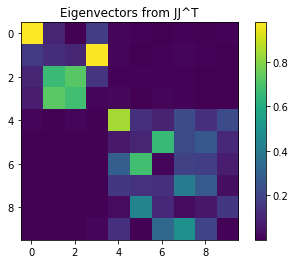

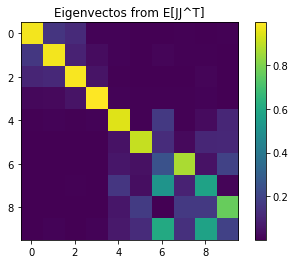

In [11]:
k = 10
V_H_k = V_H[:,:k]
U_an_k = U_an[:,:k]
U_exp_k = Exp_U[:,:k]

plt.figure()
plt.imshow(abs(V_H_k.T.dot(U_an_k)))
plt.title('Eigenvectors from JJ^T')
plt.colorbar()
plt.figure()
plt.imshow(abs(V_H_k.T.dot(U_exp_k)))
plt.title('Eigenvectos from E[JJ^T]')
plt.colorbar()


## Diagonalizing A

Error: 0.06756191803461147
Exp error: 0.05086037396905343


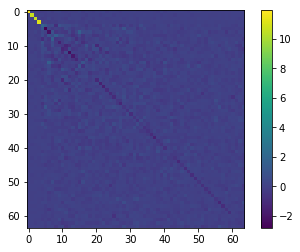

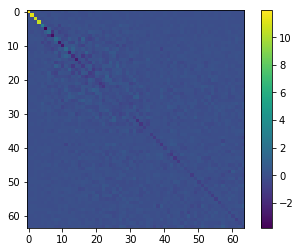

In [12]:
Diag = U_an.T.dot(A).dot(U_an)
Exp_diag = Exp_U.T.dot(A).dot(Exp_U)

print('Error:', (np.sum(np.diag(np.diag(Diag))-Diag)**2)/np.linalg.norm(A)**2)
print('Exp error:', (np.sum(np.diag(np.diag(Exp_diag))-Exp_diag)**2)/np.linalg.norm(A)**2)

plt.figure()
plt.imshow(Diag)
plt.colorbar()
plt.figure()
plt.imshow(Exp_diag)
plt.colorbar()

# Denoise signals

## Creating signals

In [13]:
def jac_signal(Sigma, U, p=0.1, first_p=True, energy=1):
    if p >= 1 and type(p) is int:
        nparams = p
    elif 0 < p and 1 > p:
        nparams = int(p*U.shape[0])
    else:
        return None
    
    xp = np.random.randn(nparams)
    xp /= np.linalg.norm(xp)
    idx = np.flip(np.argsort(np.abs(Sigma)), axis=0)
        
    if first_p:
        idx = idx[:nparams]
    else:
        idx = idx[-nparams:]
        
    x = U[:, idx].dot(xp)
        
    if energy == 1:
        return x
    elif energy >= 0 and energy < 1: 
        noise = np.random.randn(U.shape[0])
        noise /= np.linalg.norm(noise)
        return energy*x + (1-energy)*noise
    else:
        return None

    
params = 3
n_p = 0.1
# U = Exp_U
# Sigma = Exp_S
U = U_an
Sigma = Sigmas_an

x_first_aut = jac_signal(Sigma, U_aut, params)
x_first = jac_signal(Sigma, U, params)
x_last = jac_signal(Sigma, U, params, first_p=False)
x_rand = np.random.randn(G.N)
x_rand /= np.linalg.norm(x_rand)

# Adding noise
x_first_n = ds.GraphSignal.add_noise(x_first, n_p)
x_last_n = ds.GraphSignal.add_noise(x_last, n_p)
x_rand_n = ds.GraphSignal.add_noise(x_rand, n_p)
x_dw_n = ds.GraphSignal.add_noise(x_dw.x, n_p)

## Fitting noiseless signals

Model 1: Node Err:  1.1615651e-06 Err: 0.004703375529573645 Epoch: 749
Model 2: Node Err:  1.7688817e-05 Err: 0.11176976995130092 Epoch: 747
Model 3: Node Err:  2.9584753e-06 Err: 0.014211097732186317 Epoch: 750
Model 4: Node Err:  8.5515796e-07 Err: 0.006898371037095785 Epoch: 750


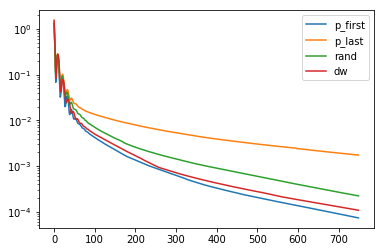

In [14]:
epochs = 750
lr = 0.001
model_first = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
model_last = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
model_rand = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
model_dw = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)

err1_n, err1, epoch = model_first.fit(x_first, x_first)
node_err, err = model_first.test(x_first)
print('Model 1: Node Err: ', node_err, 'Err:', err, 'Epoch:', epoch)

err2_n, err2, epoch = model_last.fit(x_last, x_last)
node_err, err = model_last.test(x_last)
print('Model 2: Node Err: ', node_err, 'Err:', err, 'Epoch:', epoch)

err3_n, err3, epoch = model_rand.fit(x_rand, x_rand)
node_err, err = model_rand.test(x_rand)
print('Model 3: Node Err: ', node_err, 'Err:', err, 'Epoch:', epoch)

err4_n, err4, epoch = model_dw.fit(x_dw.x, x_dw.x)
node_err, err = model_dw.test(x_dw.x)
print('Model 4: Node Err: ', node_err, 'Err:', err, 'Epoch:', epoch)

plt.figure()
plt.semilogy(err1)
plt.semilogy(err2)
plt.semilogy(err3)
plt.semilogy(err4)
plt.legend(['p_first', 'p_last', 'rand', 'dw'])

## Fitting noisy signals


Model 5: Node Err:  0.0004749644 Err: 0.07833569528019001 Epoch: 749
Model 6: Node Err:  0.001093318 Err: 0.24262137162122885 Epoch: 750
Model 7: Node Err:  0.0006498374 Err: 0.10204679518938065 Epoch: 750
Model 8: Node Err:  0.00083441957 Err: 0.1135098859667778 Epoch: 749


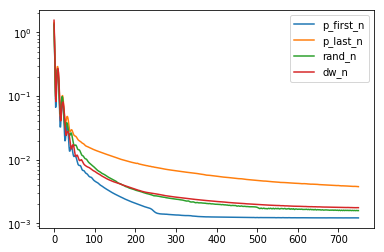

In [15]:
epochs = 750
lr = 0.001
model_first_n = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
model_last_n = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
model_rand_n = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
model_dw_n = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)

err5_n, err5, epoch = model_first_n.fit(x_first_n, x_first)
node_err, err = model_first_n.test(x_first)
print('Model 5: Node Err: ', node_err, 'Err:', err, 'Epoch:', epoch)

err6_n, err6, epoch = model_last_n.fit(x_last_n, x_last)
node_err, err = model_last_n.test(x_last)
print('Model 6: Node Err: ', node_err, 'Err:', err, 'Epoch:', epoch)

err7_n, err7, epoch = model_rand_n.fit(x_rand_n, x_rand)
node_err, err = model_rand_n.test(x_rand)
print('Model 7: Node Err: ', node_err, 'Err:', err, 'Epoch:', epoch)

err8_n, err8, epoch = model_dw_n.fit(x_dw_n, x_dw.x)
node_err, err = model_dw_n.test(x_dw.x)
print('Model 8: Node Err: ', node_err, 'Err:', err, 'Epoch:', epoch)

plt.figure()
plt.semilogy(err5)
plt.semilogy(err6)
plt.semilogy(err7)
plt.semilogy(err8)
plt.legend(['p_first_n', 'p_last_n', 'rand_n', 'dw_n'])

## Using 100 signals

In [18]:
n_signals = 100
params = 3
n_p = 0.1
epochs = 750
lr = 0.001

err = np.zeros((8, n_signals, epochs))
err_wrt_n = np.zeros((8, n_signals, epochs))
start_time = time.time()
for i in range(n_signals):
    # Create signals
    x_first = jac_signal(Sigmas_an, U_an, params)
    x_last = jac_signal(Sigmas_an, U_an, params, first_p=False)
    x_rand = np.random.randn(G.N)
    x_rand /= np.linalg.norm(x_rand)
    x_first_n = ds.GraphSignal.add_noise(x_first, n_p)
    x_last_n = ds.GraphSignal.add_noise(x_last, n_p)
    x_rand_n = ds.GraphSignal.add_noise(x_rand, n_p)
    x_dw_n = ds.GraphSignal.add_noise(x_dw.x, n_p)

    # Create Models
    model_first = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_last = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_rand = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_dw = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_first_n = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_last_n = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_rand_n = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_dw_n = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)

    # Get Error
    err_wrt_n[0, i, :], err[0, i, :], _ = model_first.fit(x_first, x_first)
    err_wrt_n[1, i, :], err[1, i, :], _ = model_last.fit(x_last, x_last)
    err_wrt_n[2, i, :], err[2, i, :], _ = model_rand.fit(x_rand, x_rand)
    err_wrt_n[3, i, :], err[3, i, :], _ = model_dw.fit(x_dw.x, x_dw.x)
    err_wrt_n[4, i, :], err[4, i, :], _ = model_first_n.fit(x_first_n, x_first)
    err_wrt_n[5, i, :], err[5, i, :], _ = model_last_n.fit(x_last_n, x_last)
    err_wrt_n[6, i, :], err[6, i, :], _ = model_rand_n.fit(x_rand_n, x_rand)
    err_wrt_n[7, i, :], err[7, i, :], _ = model_dw_n.fit(x_dw_n, x_dw.x)
    
    print('Signal', i)
print('--- {} minutes ---'.format((time.time()-start_time)/60))

Signal 0
Signal 1
Signal 2
Signal 3
Signal 4
Signal 5
Signal 6
Signal 7
Signal 8
Signal 9
Signal 10
Signal 11
Signal 12
Signal 13
Signal 14
Signal 15
Signal 16
Signal 17
Signal 18
Signal 19
Signal 20
Signal 21
Signal 22
Signal 23
Signal 24
Signal 25
Signal 26
Signal 27
Signal 28
Signal 29
Signal 30
Signal 31
Signal 32
Signal 33
Signal 34
Signal 35
Signal 36
Signal 37
Signal 38
Signal 39
Signal 40
Signal 41
Signal 42
Signal 43
Signal 44
Signal 45
Signal 46
Signal 47
Signal 48
Signal 49
Signal 50
Signal 51
Signal 52
Signal 53
Signal 54
Signal 55
Signal 56
Signal 57
Signal 58
Signal 59
Signal 60
Signal 61
Signal 62
Signal 63
Signal 64
Signal 65
Signal 66
Signal 67
Signal 68
Signal 69
Signal 70
Signal 71
Signal 72
Signal 73
Signal 74
Signal 75
Signal 76
Signal 77
Signal 78
Signal 79
Signal 80
Signal 81
Signal 82
Signal 83
Signal 84
Signal 85
Signal 86
Signal 87
Signal 88
Signal 89
Signal 90
Signal 91
Signal 92
Signal 93
Signal 94
Signal 95
Signal 96
Signal 97
Signal 98
Signal 99
--- 9.0401

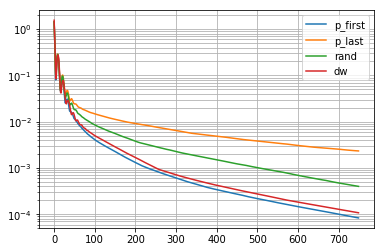

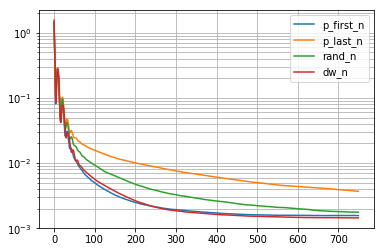

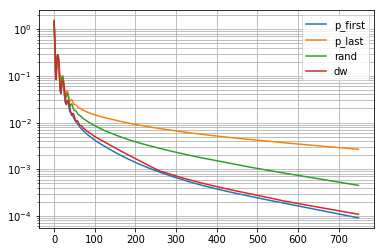

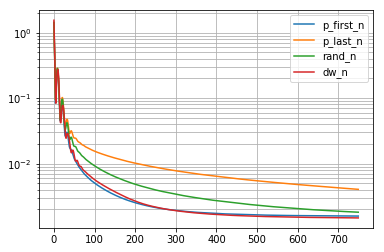

In [19]:
# median error
err_med = np.median(err, axis=1)
plt.figure()
plt.semilogy(err_med[0, :])
plt.semilogy(err_med[1, :])
plt.semilogy(err_med[2, :])
plt.semilogy(err_med[3, :])
plt.legend(['p_first', 'p_last', 'rand', 'dw'])
plt.grid(True, which='both')

plt.figure()
plt.semilogy(err_med[4, :])
plt.semilogy(err_med[5, :])
plt.semilogy(err_med[6, :])
plt.semilogy(err_med[7, :])
plt.legend(['p_first_n', 'p_last_n', 'rand_n', 'dw_n'])
plt.grid(True, which='both')

# mean error
err_mean = np.mean(err, axis=1)
plt.figure()
plt.semilogy(err_mean[0, :])
plt.semilogy(err_mean[1, :])
plt.semilogy(err_mean[2, :])
plt.semilogy(err_mean[3, :])
plt.legend(['p_first', 'p_last', 'rand', 'dw'])
plt.grid(True, which='both')

plt.figure()
plt.semilogy(err_mean[4, :])
plt.semilogy(err_mean[5, :])
plt.semilogy(err_mean[6, :])
plt.semilogy(err_mean[7, :])
plt.legend(['p_first_n', 'p_last_n', 'rand_n', 'dw_n'])
plt.grid(True, which='both')

## Preparing proyected error

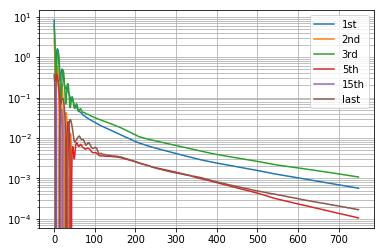

In [24]:
# Quick test
n_signals = 1
params = 3
n_p = 0.1
epochs = 750
lr = 0.001

x_first = jac_signal(Sigmas_an, U_an, params)
x_first_n = ds.GraphSignal.add_noise(x_first, n_p)
model_first = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
_, err, _ = model_first.fit(x_first, x_first, reduce_err=False)
plt.figure()
plt.semilogy(err.dot(U_an[:,0]))
plt.semilogy(err.dot(U_an[:,1]))
plt.semilogy(err.dot(U_an[:,2]))
plt.semilogy(err.dot(U_an[:,4]))
plt.semilogy(err.dot(U_an[:,14]))
plt.semilogy(err.dot(U_an[:,-1]))
plt.legend(['1st', '2nd', '3rd', '5th', '15th', 'last'])
plt.grid(True, which='both')

In [16]:
n_signals = 1
params = 3
n_p = 0.1
epochs = 750
lr = 0.001

err = np.zeros((8, n_signals, epochs, G.N))
err_wrt_n = np.zeros((8, n_signals, epochs, G.N))
start_time = time.time()
for i in range(n_signals):
    # Create signals
    x_first = jac_signal(Sigmas_an, U_an, params)
    x_last = jac_signal(Sigmas_an, U_an, params, first_p=False)
    x_rand = np.random.randn(G.N)
    x_rand /= np.linalg.norm(x_rand)
    x_first_n = ds.GraphSignal.add_noise(x_first, n_p)
    x_last_n = ds.GraphSignal.add_noise(x_last, n_p)
    x_rand_n = ds.GraphSignal.add_noise(x_rand, n_p)
    x_dw_n = ds.GraphSignal.add_noise(x_dw.x, n_p)

    # Create Models
    model_first = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_last = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_rand = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_dw = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_first_n = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_last_n = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_rand_n = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_dw_n = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)

    # Get Error
    err_wrt_n[0, i, :, :], err[0, i, :], _ = model_first.fit(x_first, x_first, reduce_err=False)
    err_wrt_n[1, i, :, :], err[1, i, :], _ = model_last.fit(x_last, x_last, reduce_err=False)
    err_wrt_n[2, i, :, :], err[2, i, :], _ = model_rand.fit(x_rand, x_rand, reduce_err=False)
    err_wrt_n[3, i, :, :], err[3, i, :], _ = model_dw.fit(x_dw.x, x_dw.x, reduce_err=False)
    err_wrt_n[4, i, :, :], err[4, i, :], _ = model_first_n.fit(x_first_n, x_first, reduce_err=False)
    err_wrt_n[5, i, :, :], err[5, i, :], _ = model_last_n.fit(x_last_n, x_last, reduce_err=False)
    err_wrt_n[6, i, :, :], err[6, i, :], _ = model_rand_n.fit(x_rand_n, x_rand, reduce_err=False)
    err_wrt_n[7, i, :, :], err[7, i, :], _ = model_dw_n.fit(x_dw_n, x_dw.x, reduce_err=False)
    
    print('Signal', i)
print('--- {} minutes ---'.format((time.time()-start_time)/60))

Signal 0
--- 0.09035067558288574 minutes ---


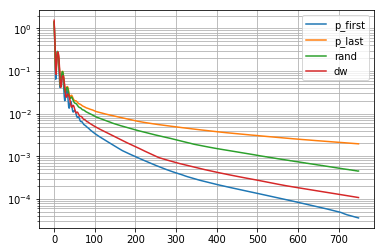

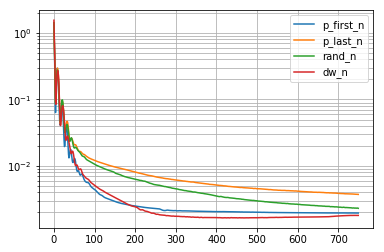

In [17]:
# Some plots
mean_node_err = np.mean(err, axis=3)
err_med = np.median(mean_node_err, axis=1)
plt.figure()
plt.semilogy(err_med[0, :])
plt.semilogy(err_med[1, :])
plt.semilogy(err_med[2, :])
plt.semilogy(err_med[3, :])
plt.legend(['p_first', 'p_last', 'rand', 'dw'])
plt.grid(True, which='both')

plt.figure()
plt.semilogy(err_med[4, :])
plt.semilogy(err_med[5, :])
plt.semilogy(err_med[6, :])
plt.semilogy(err_med[7, :])
plt.legend(['p_first_n', 'p_last_n', 'rand_n', 'dw_n'])
plt.grid(True, which='both')



In [20]:
plt.show()